# Image Restoration using Autoencoders
In this exercise, we model a denoising autoencoder to restore corrupted images of the MNISTdata set. 

Input: Input data is an MNIST image corrupted by a white square of at most 25% of the image area
Output: Restored MNIST image w/o the corrupting white square.

Notes:
1. Area of white square follows a uniform distribution over [6.25, 25] percent of the image area. That is, the dimension of the square should be sampled from: S = [7, 14] pixels.
2. Position of white square is randomly chosen. The x- and y-coordinates of the top-left corner are independently sampled from a uniform distribution over [0, 28 - S], where S is the length of the white square's side.


(60000, 28, 28, 1)
(10000, 28, 28, 1)


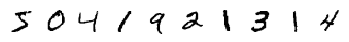

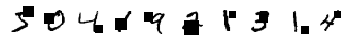

In [3]:
from transforms import *
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train_corrupted = corrupt_mnist_copy(X_train)
X_test_corrupted = corrupt_mnist_copy(X_test)
X_train = X_train.astype('float32')/255
X_train_corrupted = X_train_corrupted.astype('float32')/255
X_test = X_test.astype('float32')/255

image_size = X_train.shape[1]
X_train = np.reshape(X_train, [-1, image_size, image_size, 1])
X_train_corrupted = np.reshape(X_train_corrupted, [-1, image_size, image_size, 1])
X_test = np.reshape(X_test, [-1, image_size, image_size, 1])
X_test_corrupted = np.reshape(X_test_corrupted, [-1, image_size, image_size, 1])
print(X_train.shape)
print(X_test.shape)

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(28,28),  cmap='Greys')
    plt.axis('off')    
plt.show()

for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train_corrupted[i].reshape(28,28),  cmap='Greys')
    plt.axis('off')    
plt.show()

In [7]:
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose,Dropout,K, Flatten, Reshape
from keras.models import Model
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 256
kernel_size = 5
latent_dim = 32
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
    x = Dropout(0.1)(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
    x = Dropout(0.3)(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                200736    
Total para

In [8]:
from keras import callbacks,regularizers
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

es = callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto',restore_best_weights=True)
# train the autoencoder
history = autoencoder.fit(X_train_corrupted,
                X_train,
                validation_data=(X_test_corrupted, X_test),
                epochs=20,
                verbose = 0,
                batch_size=batch_size,
                callbacks=[es]
                )

W1015 22:19:34.812202 18308 deprecation_wrapper.py:119] From C:\Users\Ellysah\Anaconda3\envs\keras-gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 32)                407328    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         823169    
Total params: 1,230,497
Trainable params: 1,230,497
Non-trainable params: 0
_________________________________________________________________


W1015 22:19:35.216165 18308 deprecation_wrapper.py:119] From C:\Users\Ellysah\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



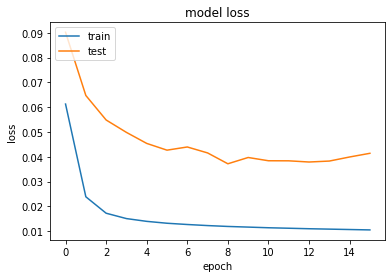

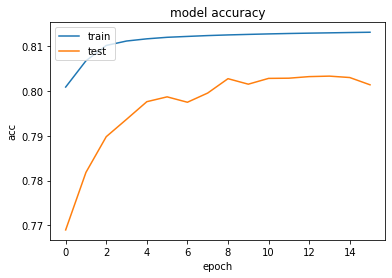

10000/10000 [==============================] - 5s 463us/step

Test accuracy: 80.3%


In [9]:
import matplotlib.pyplot as plt
def plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

plot(history)

loss, acc = autoencoder.evaluate(X_test_corrupted, X_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

In [35]:
import benchmark_keras,imp
from benchmark_keras import test_model
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale to [0, 1]
x_test = x_test / 255
# model is your Keras model
# DO NOT convert y_test, i.e. don't use keras.utils.to_categorical()
imp.reload(benchmark_keras)
print(x_test.shape)
benchmark_keras.test_model(autoencoder, x_test, y_test, batch_size=100)

(10000, 28, 28)
96
192
288
385
482
578
670
766
861
958
1055
1152
1249
1347
1443
1539
1636
1733
1829
1924
2019
2116
2214
2308
2405
2499
2595
2692
2790
2883
2983
3075
3171
3268
3363
3457
3552
3648
3741
3838
3935
4033
4133
4227
4325
4422
4519
4617
4715
4810
4907
5004
5100
5198
5297
5397
5493
5590
5686
5784
5880
5979
6074
6171
6269
6364
6462
6559
6653
6749
6846
6942
7039
7135
7230
7327
7424
7520
7615
7711
7810
7908
8007
8106
8203
8298
8393
8490
8587
8685
8784
8878
8974
9071
9170
9266
9363
9461
9559
9656
HuyClassifier score: 1285.75
SSIM score: 94.23
9656
751


In [167]:
# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(X_test_corrupted)

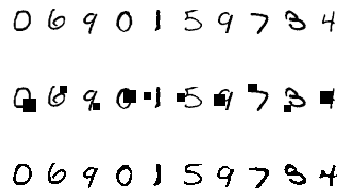

In [168]:
numimages = 10
start = 10
for i in range(numimages):
    plt.subplot(3, numimages, i+1)
    plt.imshow(X_test[start+i].reshape(28,28),  cmap='Greys')
    plt.axis('off')    
    plt.subplot(3, numimages, numimages+i+1)
    plt.imshow(X_test_corrupted[start+i].reshape(28,28),  cmap='Greys')
    plt.axis('off') 
    plt.subplot(3, numimages, 2*numimages+i+1)
    plt.imshow(x_decoded[start+i].reshape(28,28),  cmap='Greys')
    plt.axis('off')  
plt.show()
